## Project Goals

Understand how RNNs capture temporal dependencies.

Compare RNN vs. Feedforward NN on stock price prediction.

Explore improvements using Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU).

Tune sequence length, regularization, and hyperparameters to optimize performance.

## Dataset

Source: AAPL

Download: Yahoo Finance

Features to use: Date, Close (or Adj Close)

Frequency: Daily closing prices.

In [14]:
!pip install yfinance



### Data Collection and Preprocessing

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, GRU

# Download AAPL stock data
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
data = data[['Close']]
data.dropna(inplace=True)


C:\Users\bbuser\AppData\Local\Temp\ipykernel_21456\1013004027.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


## Normalize Data

In [5]:
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

values = data['Close'].values


## Helper Functions

In [6]:
def create_lagged_features(series, lag=10):
    """
    Convert a 1D series into X, y for feedforward model
    using fixed-size lag window
    """
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

def train_test_split_time(X, y, train_ratio=0.8):
    split = int(len(X) * train_ratio)
    return X[:split], X[split:], y[:split], y[split:]


## Create Lagged Features for Feedforward NN

In [7]:
LAG = 30  # number of past days to use as input
X_ff, y_ff = create_lagged_features(values, LAG)
X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split_time(X_ff, y_ff)


### Feedforward Neural Network

In [8]:
model_ff = Sequential([
    Dense(64, activation='relu', input_shape=(LAG,)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ff.compile(optimizer='adam', loss='mae')
history_ff = model_ff.fit(X_train_ff, y_train_ff, epochs=20, validation_data=(X_test_ff, y_test_ff), verbose=1)

pred_ff = model_ff.predict(X_test_ff)
mae_ff = mean_absolute_error(y_test_ff, pred_ff)
print(f"Feedforward NN MAE: {mae_ff:.4f}")



C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0431 - val_loss: 0.0266
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0195 - val_loss: 0.0209
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0199 - val_loss: 0.0332
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0183 - val_loss: 0.0209
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0182 - val_loss: 0.0226
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0166 - val_loss: 0.0186
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0157 - val_loss: 0.0182
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0186 - val_loss: 0.0439
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0152 - val_loss: 0.0331
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

### Prepare Data for LSTM/GRU

In [9]:
def create_sequences(series, seq_length):
    X, y = [], []
    for i in range(seq_length, len(series)):
        X.append(series[i-seq_length:i])
        y.append(series[i])
    return np.array(X), np.array(y)

SEQ_LEN = 30
X_rnn, y_rnn = create_sequences(values, SEQ_LEN)
X_rnn = X_rnn.reshape((X_rnn.shape[0], X_rnn.shape[1], 1))

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split_time(X_rnn, y_rnn)


## LSTM Model

In [10]:
model_lstm = Sequential([
    LSTM(50, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mae')
history_lstm = model_lstm.fit(X_train_rnn, y_train_rnn, epochs=20, validation_data=(X_test_rnn, y_test_rnn), verbose=1)

pred_lstm = model_lstm.predict(X_test_rnn)
mae_lstm = mean_absolute_error(y_test_rnn, pred_lstm)
print(f"LSTM MAE: {mae_lstm:.4f}")


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.1533 - val_loss: 0.0522
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0356 - val_loss: 0.0281
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0241 - val_loss: 0.0319
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0225 - val_loss: 0.0241
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0215 - val_loss: 0.0258
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0203 - val_loss: 0.0227
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0196 - val_loss: 0.0258
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0200 - val_loss: 0.0215
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0209 - val_loss: 0.0235
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0186 - val_loss: 0.0229
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0176 - val_loss: 0.0200
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0

## GRU Model

In [11]:
model_gru = Sequential([
    GRU(50, input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mae')
history_gru = model_gru.fit(X_train_rnn, y_train_rnn, epochs=20, validation_data=(X_test_rnn, y_test_rnn), verbose=1)

pred_gru = model_gru.predict(X_test_rnn)
mae_gru = mean_absolute_error(y_test_rnn, pred_gru)
print(f"GRU MAE: {mae_gru:.4f}")


Epoch 1/20


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.1220 - val_loss: 0.1123
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0335 - val_loss: 0.0399
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0152 - val_loss: 0.0188
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0136 - val_loss: 0.0161
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0133 - val_loss: 0.0138
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0125 - val_loss: 0.0143
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0127 - val_loss: 0.0142
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0125 - val_loss: 0.0136
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0131 - val_loss: 0.0186
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0118 - val_loss: 0.0140
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0122 - val_loss: 0.0179
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0130 - val_l

## Compare Models and Plot Predictions

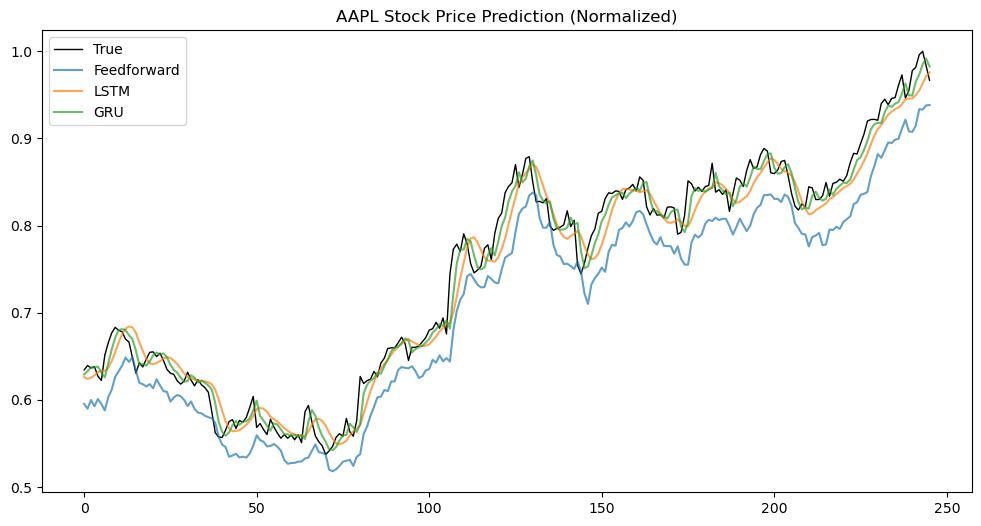

MAE - Feedforward NN: 0.0403
MAE - LSTM: 0.0178
MAE - GRU: 0.0120


In [12]:
plt.figure(figsize=(12,6))
plt.plot(y_test_ff, label='True', color='black', linewidth=1)
plt.plot(pred_ff, label='Feedforward', alpha=0.7)
plt.plot(pred_lstm, label='LSTM', alpha=0.7)
plt.plot(pred_gru, label='GRU', alpha=0.7)
plt.title('AAPL Stock Price Prediction (Normalized)')
plt.legend()
plt.show()

print(f"MAE - Feedforward NN: {mae_ff:.4f}")
print(f"MAE - LSTM: {mae_lstm:.4f}")
print(f"MAE - GRU: {mae_gru:.4f}")


### Models with temporal memory (LSTM and GRU) are much more effective than simple feedforward networks for stock time series forecasting.
so,  GRU performed best — giving the lowest prediction error.